## An ipython notebook if you want to test it in google colab

In [1]:
# an ipython notebook if you want to test it in google colab
from shutil import copyfile
import os
import numpy as np
import DeepImageUtils as IU
from scipy.spatial import distance
from matplotlib import pyplot as plt

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
219062272/219055592 [==============================] - 15s 0us/step


##CreateDatabase.py

In [0]:
def MakeDirChecked(path):
    if not os.path.isdir(path):
        os.mkdir(path)

In [3]:
root_folder = input('Enter the path of the image dataset root folder: \n')
root_folder = os.path.realpath(root_folder)

if not os.path.isdir(root_folder):
    print('no such folder:', root_folder)
    exit(1)

Enter the path of the image dataset root folder: 
/content/drive/My Drive/dataset


In [4]:
database_path = input('Enter the path to create the root folder of the database in: \n')
database_path = os.path.join(database_path, 'database')
database_path = os.path.realpath(database_path)

Enter the path to create the root folder of the database in: 
/content


In [5]:
# get the path to all image files in the root folder
image_paths = IU.GetAllImagesInPath(root_folder)

# the root create database folder
MakeDirChecked(database_path)
for img_path in image_paths:
    # predict the categories of every image in the dataset 
    categories = IU.PredictImageCategory(img_path)

    # create a folder for every category to easily separate the data reducing search times
    for category in categories:
        category_path =  os.path.join(database_path, category) + '/'
        # create the directory for the category
        MakeDirChecked(category_path)
        # copy the image to the category folder
        # could potentially just save the extracted features there and have a reference to the place of the orignal image path
        # having a reference might help with avoiding duplicates and copy times if you don't need a backup
        # and if you are scapping the web you can just link to the original image in the features database to retrun that link later
        copy_path = os.path.join(category_path, IU.Path2Name(img_path))
        copyfile(img_path, copy_path)

40960/35363 [==================================] - 0s 5us/step


In [0]:
# get all the created category folders in the database directory
category_folders = IU.GetAllFolderInPath(database_path)

# for every category create the feature vector for the images of that category present in the category file
for category_folder in category_folders:
    feature_vectors = []
    # get all image file paths' in the category's folder
    database_image_paths = IU.GetAllImagesInPath(category_folder)
    
    # extract the features of each image and append it to the feature list of that category
    # this is where you would put the link or the other path of the image instead of the local one
    for database_image_path in database_image_paths:
        img_features = [database_image_path, IU.CreateImageFeaturesVector(database_image_path)]
        feature_vectors.append(img_features)
  
  
    # save the features as a compressed numpy array object with the name of the category
    feature_file_name = IU.Path2Name(category_folder[:-1]) + '.npz'
    features_path = os.path.join(category_folder, feature_file_name)
    np.savez_compressed(features_path, feature_vectors)

##RetrieveImage.py

In [7]:
database_path = input('Enter the path to the root directory of the database (named databse): \n')
database_path = os.path.realpath(database_path)

if not os.path.isdir(database_path):
    print('No such directory:', database_path)
    exit(1)

Enter the path to the root directory of the database (named databse): 
/content/database
/content/database


In [8]:
query_img_path = input('Enter query image path:\n')
query_img_path = os.path.realpath(query_img_path)

if not os.path.isfile(query_img_path):
    print('No such file:', query_img_path)
    exit(1)

Enter query image path:
cat27.jpg


In [0]:
query_img_categories = IU.PredictImageCategory(query_img_path)
img_features_vector = IU.CreateImageFeaturesVector(query_img_path)

# saving features and loading them when a query is need is slightly faster and less memory intensive than extracting the features dueing runtime
feature_vectors = []
for category in query_img_categories:
    category_path = os.path.join(database_path, category, category + '.npz')
    
    if not os.path.isfile(category_path):
        continue

    loaded_feature_vectors = np.load(category_path, allow_pickle=True)
    loaded_feature_vectors = list(loaded_feature_vectors['arr_0'])
    # only add every image once (using the image name as a reference since that shouldn't be duplicated)
    for loaded_feature_vector in loaded_feature_vectors:
        if IU.Path2Name(loaded_feature_vector[0]) in (IU.Path2Name(feature_vector[0]) for feature_vector in feature_vectors):
            continue
      
        feature_vectors.append(loaded_feature_vector)

In [0]:
if not feature_vectors:
    # no maching images found in the database
    print('No matching images found.')
    # Display original image and exit script
    plt.figure()
    query_img = IU.OpenImage(query_img_path)
    plt.axis('off')
    plt.title('No matching images found')
    plt.imshow(query_img)
    plt.show()
    exit()

In [0]:
# Sort the list of feature vectors based on the maximum cosine similarity (min distance) to the query image's feature vector
feature_vectors.sort(key=lambda feature_vector: distance.cosine(feature_vector[1], img_features_vector))

In [0]:
def GetTilteforMatchingImage(i):
    i = str(i)
    if i.endswith('1'):
        return i + 'st matching image'
    if i.endswith('2'):
        return i + 'nd matching image'
    if i.endswith('3'):
        return i + 'rd matching image'
    
    return i + 'th matching image'

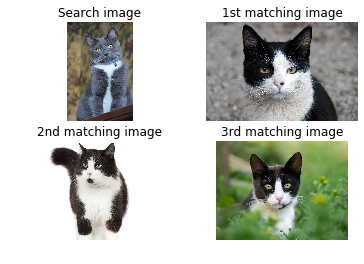

In [13]:
n_matching_images_to_show = 3
n_cols = 2
n_rows = 2


# Display all results, alongside original image
results_figure=plt.figure()

query_img = IU.OpenImage(query_img_path)

results_figure.add_subplot(n_rows, n_cols, 1)
plt.axis('off')
plt.title('Search image')
plt.imshow(query_img)

# show the selected number of closest images

if n_matching_images_to_show > n_rows * n_cols:
    n_matching_images_to_show = n_rows * n_cols

if n_matching_images_to_show > len(feature_vectors):
    n_matching_images_to_show = len(feature_vectors)
else:
    feature_vectors = feature_vectors[:n_matching_images_to_show]

for i in range(0, n_matching_images_to_show):
    results_figure.add_subplot(n_rows, n_cols, i+2)
    plt.axis('off')
    plt.title(GetTilteforMatchingImage(i+1))
    # read image file
    match = IU.OpenImage(feature_vectors[i][0])
    plt.imshow(match)



plt.show()